# Latent components (symmetry)

We would like to evaluate what the best method of identifying latent components is, between:

- Components with different IG and AP scores in the same direction (proxy latent components)
- Components with high IG symmetry (removing noise from the complete circuit)

### Set up

In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch import Tensor
from transformer_lens import HookedTransformer
from transformer_lens.utils import get_device

from attribution_methods import integrated_gradients, activation_patching, highlight_components, asymmetry_score
from testing import Task, TaskDataset, logit_diff_metric, average_correlation, measure_overlap, test_multi_ablated_performance
from plotting import plot_attn, plot_attn_comparison, plot_correlation, plot_correlation_comparison, plot_bar_chart

/vol/bitbucket/mwl21/fypvenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.set_grad_enabled(False)
torch.cuda.empty_cache()

device = get_device()
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

# Explicitly calculate and expose the result for each attention head
model.set_use_attn_result(True)
model.set_use_hook_mlp_in(True)

Loaded pretrained model gpt2-small into HookedTransformer


In [3]:
ig_corrupt_clean_mlp = torch.load("results/latent_components/ioi/ig_corrupt_clean_mlp.pt")
ap_corrupt_clean_mlp = torch.load("results/latent_components/ioi/ap_corrupt_clean_mlp.pt")

ig_corrupt_clean_attn = torch.load("results/latent_components/ioi/ig_corrupt_clean_attn.pt")
ap_corrupt_clean_attn = torch.load("results/latent_components/ioi/ap_corrupt_clean_attn.pt")

ig_clean_corrupt_mlp = torch.load("results/latent_components/ioi/ig_clean_corrupt_mlp.pt")
ap_clean_corrupt_mlp = torch.load("results/latent_components/ioi/ap_clean_corrupt_mlp.pt")

ig_clean_corrupt_attn = torch.load("results/latent_components/ioi/ig_clean_corrupt_attn.pt")
ap_clean_corrupt_attn = torch.load("results/latent_components/ioi/ap_clean_corrupt_attn.pt")

## Identifying latent components

In [4]:
# Latent components are those which have high AP asymmetry

ap_mlp_asymmetry = asymmetry_score(ap_corrupt_clean_mlp, ap_clean_corrupt_mlp, is_ig=False)
ap_attn_asymmetry = asymmetry_score(ap_corrupt_clean_attn, ap_clean_corrupt_attn, is_ig=False)

true_latent_mlp, true_latent_mlp_indices = highlight_components(ap_mlp_asymmetry)
true_latent_attn, true_latent_attn_indices = highlight_components(ap_attn_asymmetry)

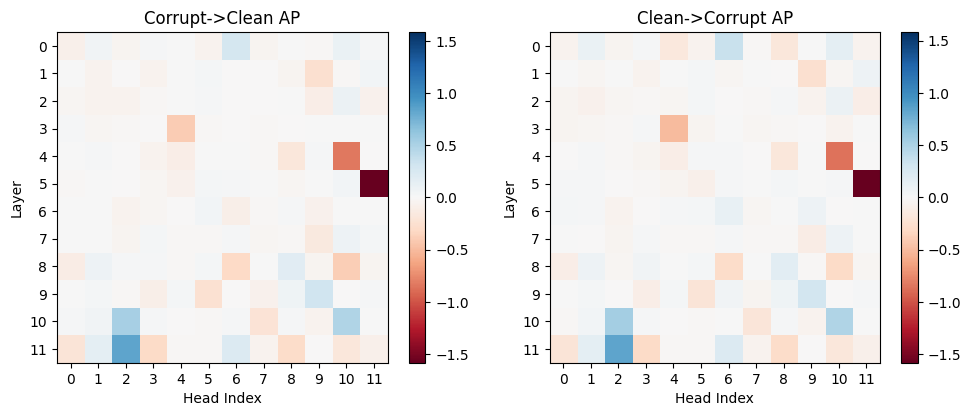

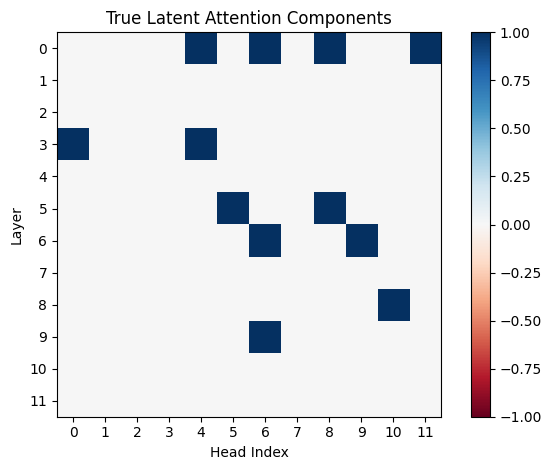

In [13]:
# Example of true latent attention components

plot_attn_comparison(ap_corrupt_clean_attn[:1], ap_clean_corrupt_attn[:1], model, "Corrupt->Clean AP", "Clean->Corrupt AP")

plot_attn(true_latent_attn[0].int(), model, title="True Latent Attention Components")

## Identify complete circuit

In [29]:
def abs_max_tensors(x, y):
    """Get the union of two tensors, taking the value with greater magnitude."""
    mins = torch.max(torch.abs(x), torch.abs(y))

    xSigns = (mins == torch.abs(x)) * torch.sign(x)
    ySigns = (mins == torch.abs(y)) * torch.sign(y)
    finalSigns = xSigns.int() | ySigns.int()

    return mins * finalSigns

In [33]:
# Union of components with high AP scores in each direction
max_attn = abs_max_tensors(ap_corrupt_clean_attn, ap_clean_corrupt_attn)
max_mlp = abs_max_tensors(ap_corrupt_clean_mlp, ap_clean_corrupt_mlp)

complete_attn = highlight_components(max_attn, 0.8)[0]
complete_mlp = highlight_components(max_mlp, 0.8)[0]

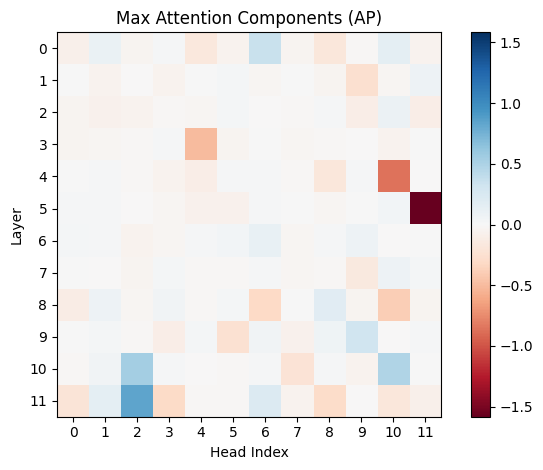

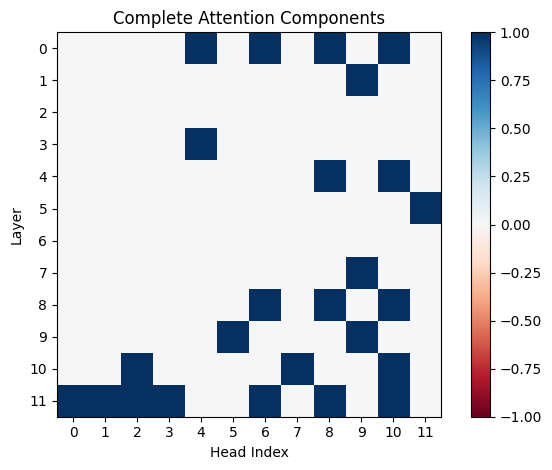

In [34]:
plot_attn(max_attn[0], model, title="Max Attention Components (AP)")
plot_attn(complete_attn[0].int(), model, title="Complete Attention Components")

## Experiment

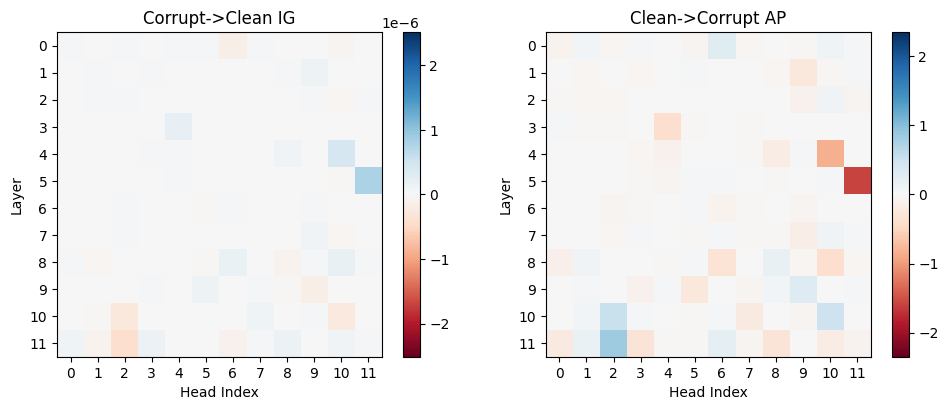

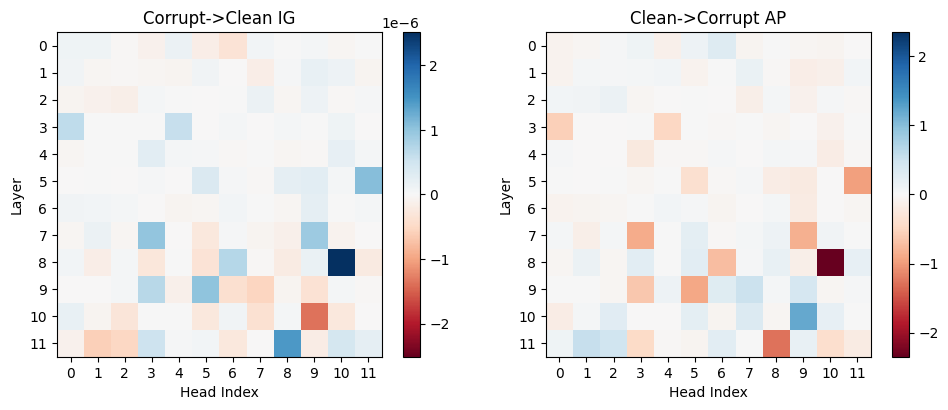

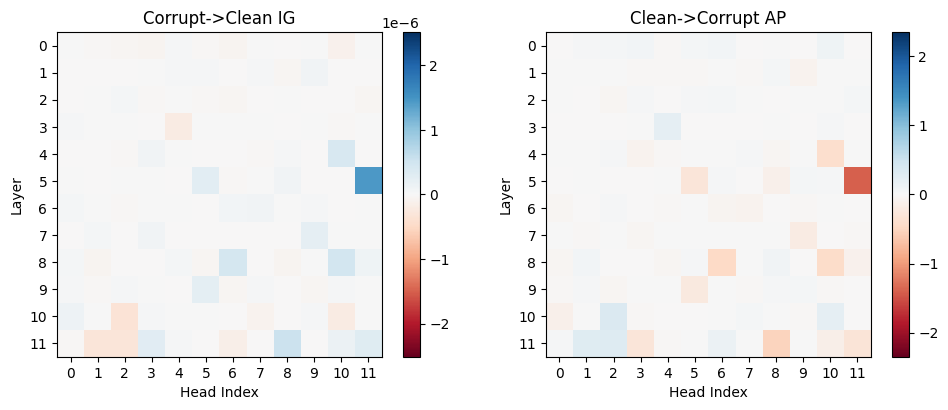

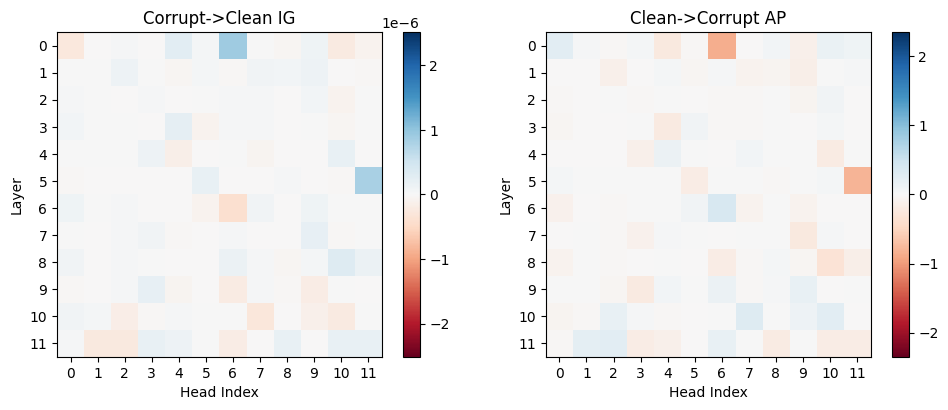

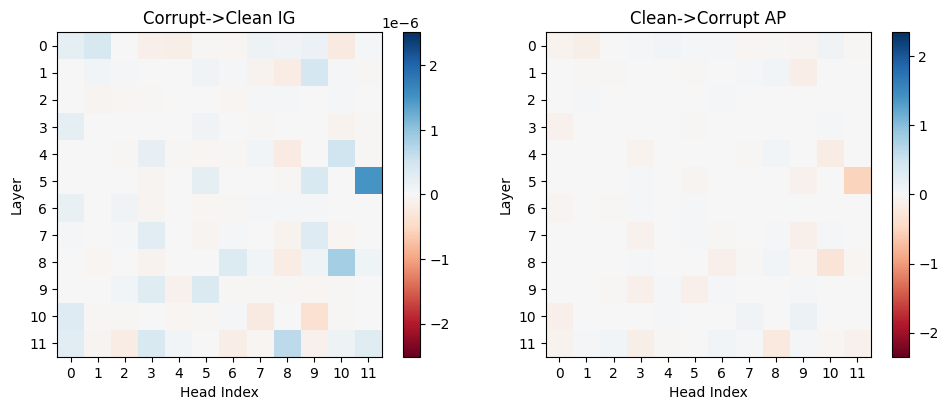

: 

In [ ]:
plot_attn_comparison(ig_corrupt_clean_attn[:5], ap_corrupt_clean_attn[:5], model, "Corrupt->Clean IG", "Clean->Corrupt AP")

In [36]:
# Components with different IG and AP scores
ig_ap_attn_asymmetry = asymmetry_score(ig_corrupt_clean_attn, ap_corrupt_clean_attn, is_ig=True)
ig_ap_mlp_asymmetry = asymmetry_score(ig_corrupt_clean_mlp, ap_corrupt_clean_mlp, is_ig=True)

ig_ap_attn = highlight_components(ig_ap_attn_asymmetry, 0.8)[0]
ig_ap_mlp = highlight_components(ig_ap_mlp_asymmetry, 0.8)[0]

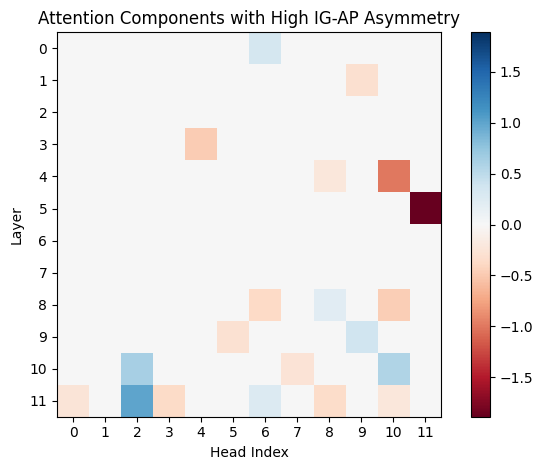

In [37]:
plot_attn((ig_ap_attn * ig_ap_attn_asymmetry)[0], model, title="Attention Components with High IG-AP Asymmetry")

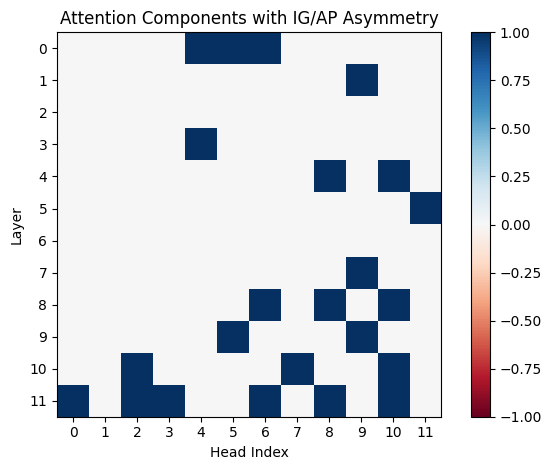

In [27]:
plot_attn(ig_ap_attn[0].int(), model, title="Attention Components with IG/AP Asymmetry")

In [38]:
# Components with high IG symmetry

ig_attn_asymmetry = asymmetry_score(ig_corrupt_clean_attn, ig_clean_corrupt_attn, is_ig=True)
ig_mlp_asymmetry = asymmetry_score(ig_corrupt_clean_mlp, ig_clean_corrupt_mlp, is_ig=True)

# Take components with lowest asymmetry
ig_agree_attn = highlight_components(1 / ig_attn_asymmetry, 0.8)[0]
ig_agree_mlp = highlight_components(1 / ig_mlp_asymmetry, 0.8)[0]

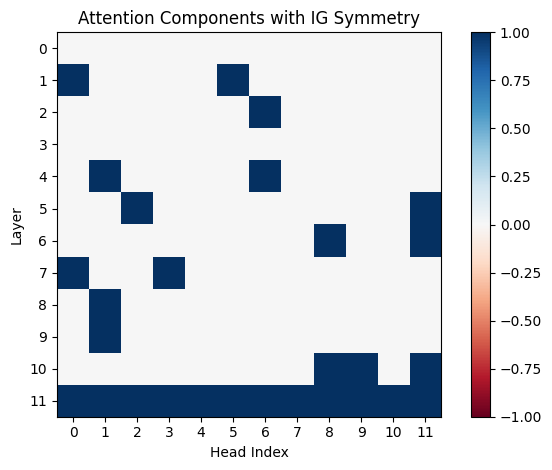

In [39]:
plot_attn(ig_agree_attn[0].int(), model, title="Attention Components with IG Symmetry")

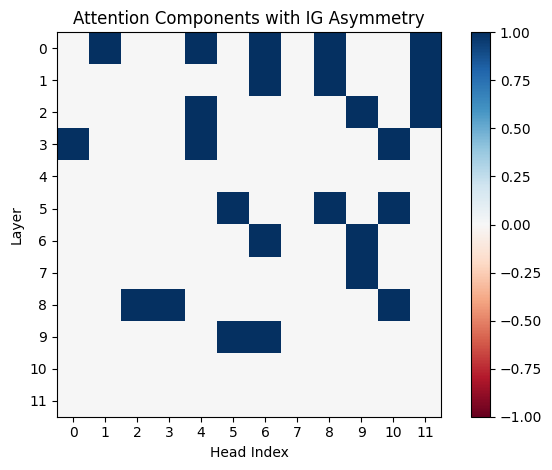

In [47]:
# Components with high IG asymmetry
ig_disagree_attn = highlight_components(ig_attn_asymmetry, 0.8)[0]
ig_disagree_mlp = highlight_components(ig_mlp_asymmetry, 0.8)[0]

plot_attn(ig_disagree_attn[0].int(), model, title="Attention Components with IG Asymmetry")

### Analysis

In [42]:
print(f"Average overlap between IG/AP asymmetry and complete circuit attention heads: {measure_overlap(ig_ap_attn, complete_attn).mean()}")
print(f"Average overlap between IG/AP asymmetry and true latent attention heads: {measure_overlap(ig_ap_attn, true_latent_attn).mean()}")

print(f"Average overlap between IG/AP asymmetry and complete circuit neurons: {measure_overlap(ig_ap_mlp, complete_mlp).mean()}")
print(f"Average overlap between IG/AP asymmetry and true latent neurons: {measure_overlap(ig_ap_mlp, true_latent_mlp).mean()}")

Average overlap between IG/AP asymmetry and complete circuit attention heads: 0.5620310306549072
Average overlap between IG/AP asymmetry and true latent attention heads: 0.21526099741458893
Average overlap between IG/AP asymmetry and complete circuit neurons: 0.4153691828250885
Average overlap between IG/AP asymmetry and true latent neurons: 0.26558440923690796


In [43]:
print(f"Average overlap between IG symmetry and complete circuit attention heads: {measure_overlap(ig_agree_attn, complete_attn).mean()}")
print(f"Average overlap between IG symmetry and true latent attention heads: {measure_overlap(ig_agree_attn, true_latent_attn).mean()}")
print(f"Average overlap between IG symmetry and complete circuit neurons: {measure_overlap(ig_agree_mlp, complete_mlp).mean()}")
print(f"Average overlap between IG symmetry and true latent neurons: {measure_overlap(ig_agree_mlp, true_latent_mlp).mean()}")

Average overlap between IG symmetry and complete circuit attention heads: 0.08617407828569412
Average overlap between IG symmetry and true latent attention heads: 0.00048719148617237806
Average overlap between IG symmetry and complete circuit neurons: 0.03513222560286522
Average overlap between IG symmetry and true latent neurons: 0.0006607893155887723


## Test correlations

We test if there is any relationship between AP asymmetry (true measure of latent components) and:

- IG scores from clean -> corrupt
- IG scores from corrupt -> clean
- IG asymmetry scores
- IG/AP asymmetry scores

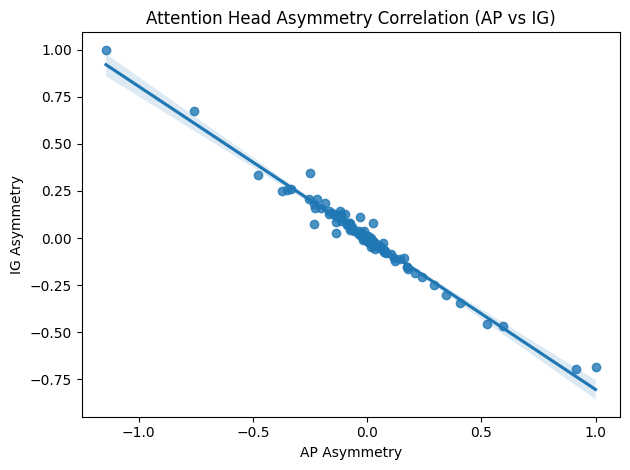

Correlation coefficient: -0.9866347137756986


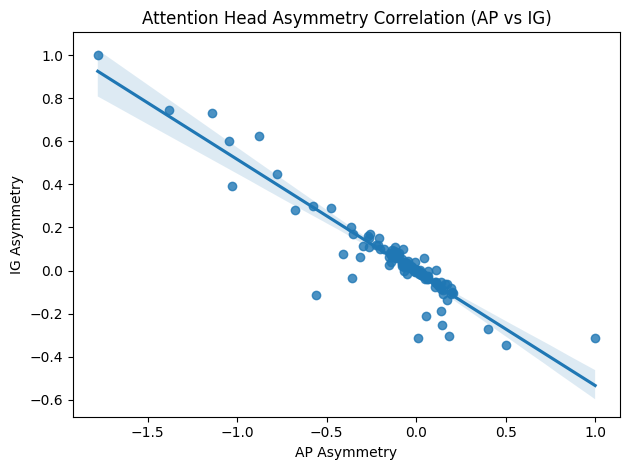

Correlation coefficient: -0.9261904007005617


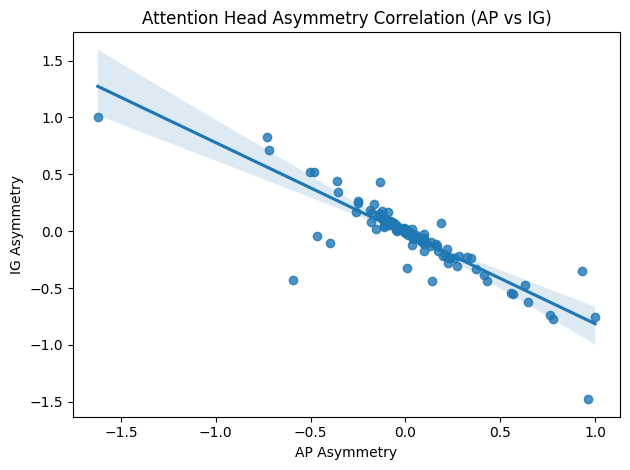

Correlation coefficient: -0.8702778766596877


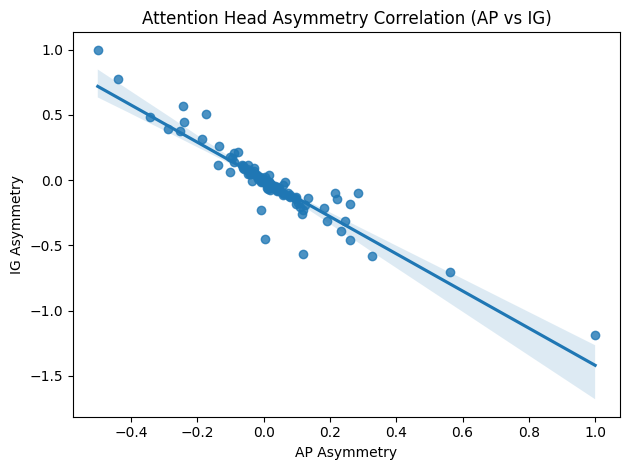

Correlation coefficient: -0.9266613509059318


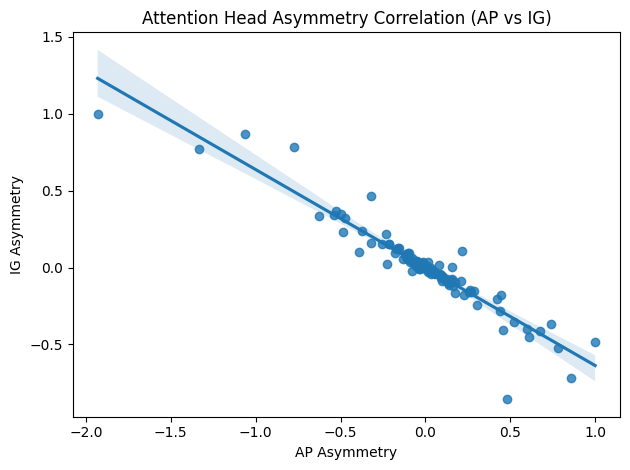

Correlation coefficient: -0.9435334304827104


In [48]:
plot_correlation(ap_attn_asymmetry[:5], ig_attn_asymmetry[:5], "AP Asymmetry", "IG Asymmetry", "Attention Head Asymmetry Correlation (AP vs IG)")

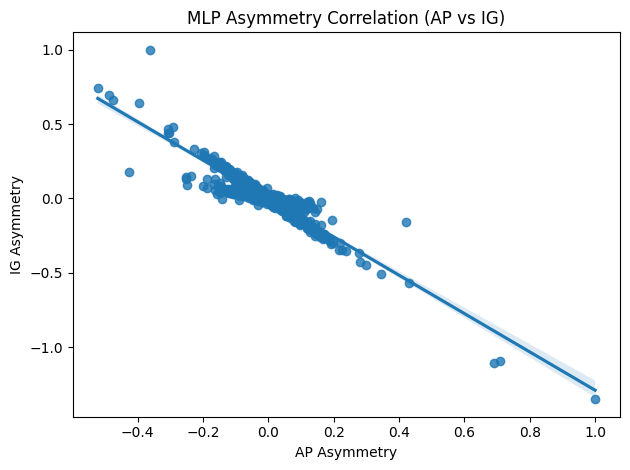

Correlation coefficient: -0.9406883011348042


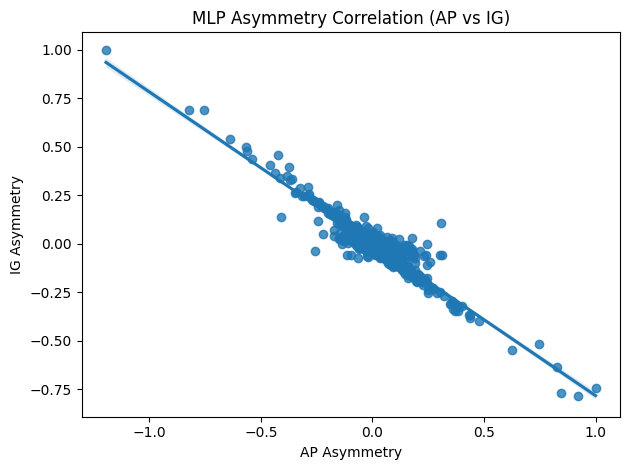

Correlation coefficient: -0.9505087112941953


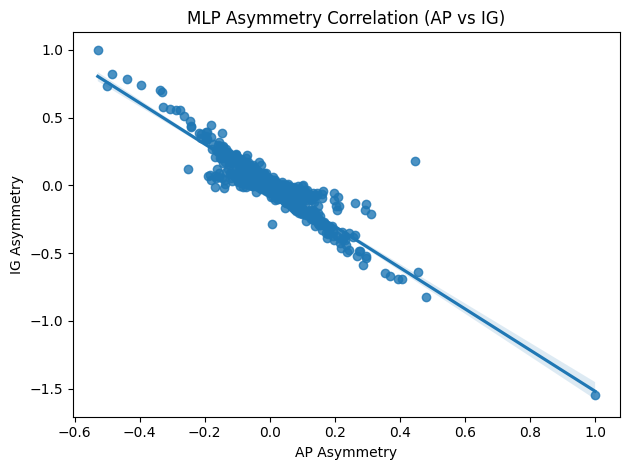

Correlation coefficient: -0.9324087721537442


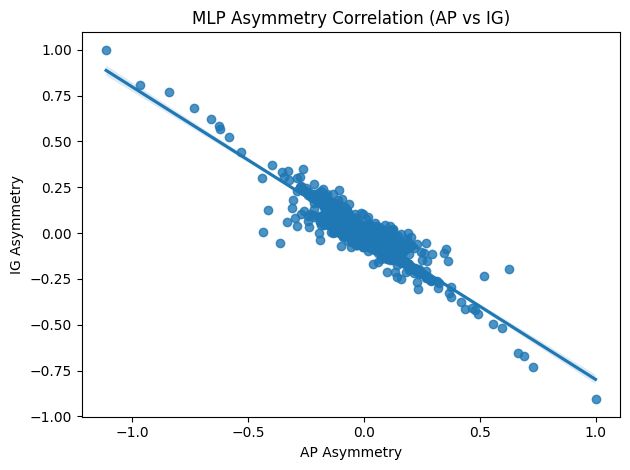

Correlation coefficient: -0.9281319115279675


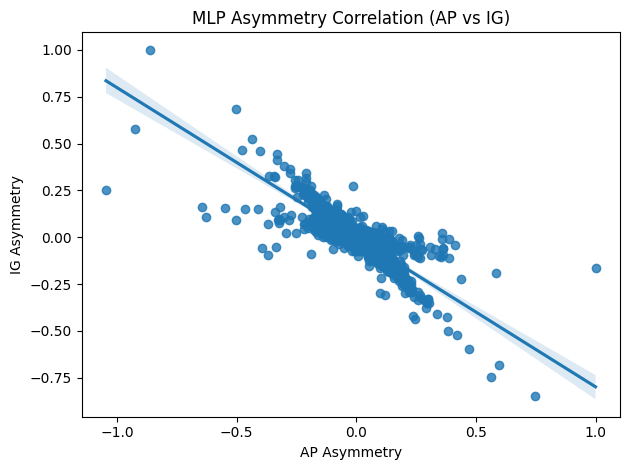

Correlation coefficient: -0.8517049916085656


In [52]:
plot_correlation(ap_mlp_asymmetry[:5], ig_mlp_asymmetry[:5], "AP Asymmetry", "IG Asymmetry", "MLP Asymmetry Correlation (AP vs IG)")

In [50]:
print(f"Average correlation between AP and IG asymmetry for attention heads: {average_correlation(ap_attn_asymmetry, ig_attn_asymmetry)}")
print(f"Average correlation between AP and IG asymmetry for MLP neurons: {average_correlation(ap_mlp_asymmetry, ig_mlp_asymmetry)}")

Average correlation between AP and IG asymmetry for attention heads: (np.float64(-0.7648895811025834), np.float64(0.5443200153498045))
Average correlation between AP and IG asymmetry for MLP neurons: (np.float64(-0.7661495519351667), np.float64(0.5307788997717975))


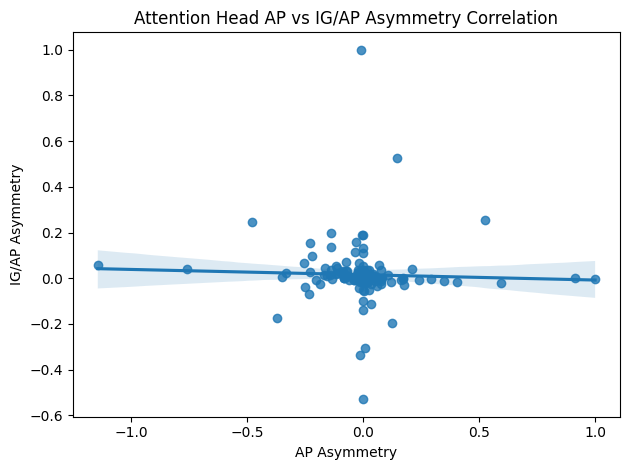

Correlation coefficient: -0.03898643199742111


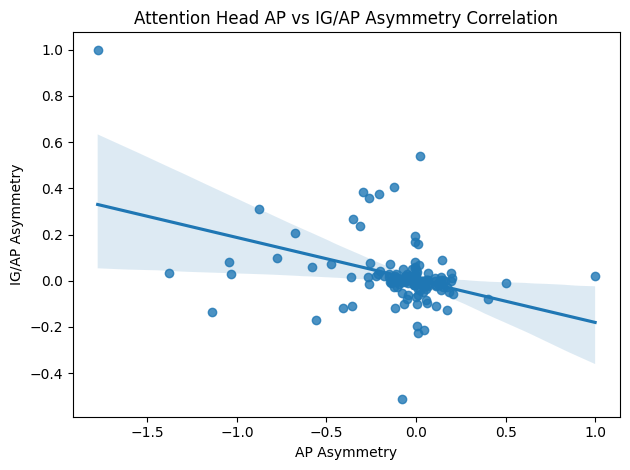

Correlation coefficient: -0.40259928789390464


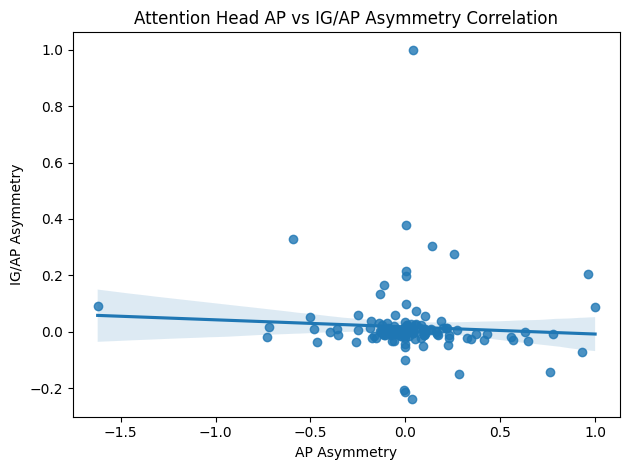

Correlation coefficient: -0.06629252936493994


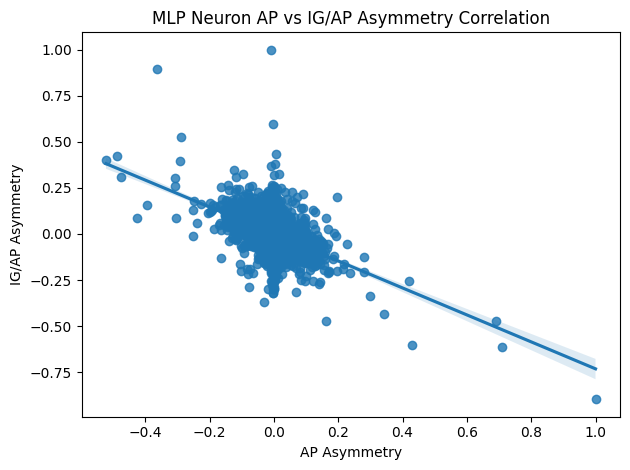

Correlation coefficient: -0.44183507557049806


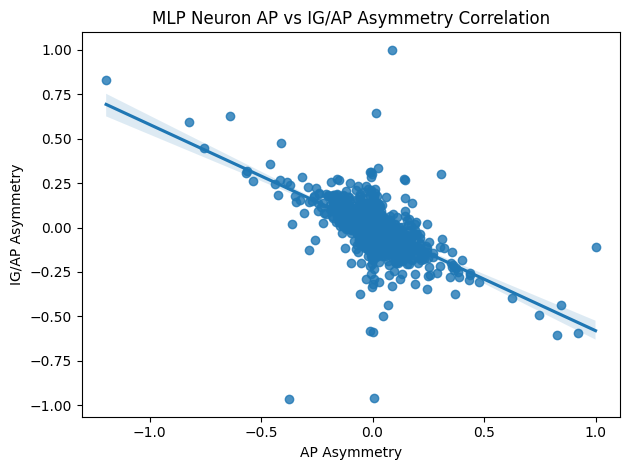

Correlation coefficient: -0.556784989332625


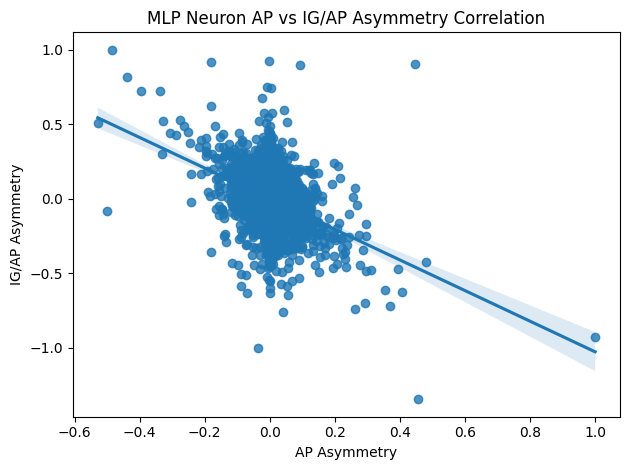

Correlation coefficient: -0.36669956643981694


In [54]:
plot_correlation(ap_attn_asymmetry[:3], ig_ap_attn_asymmetry[:3], "AP Asymmetry", "IG/AP Asymmetry", "Attention Head AP vs IG/AP Asymmetry Correlation")
plot_correlation(ap_mlp_asymmetry[:3], ig_ap_mlp_asymmetry[:3], "AP Asymmetry", "IG/AP Asymmetry", "MLP Neuron AP vs IG/AP Asymmetry Correlation")